In [1]:
import zipfile

with zipfile.ZipFile("/content/monet_jpg.zip", "r") as zip_ref:
    zip_ref.extractall("/content/monet_jpg")

In [2]:
import os

DATA_DIR = './monet_jpg'
print(os.listdir(DATA_DIR))

['monet_jpg(Artistic_images)']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 256
batch_size = 30
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder('/content/monet_jpg', transform=T.Compose([
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=25):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=5).permute(1, 2, 0))

def show_batch(dl, nmax=25):
    for images, _ in dl:
        show_images(images, nmax)
        break

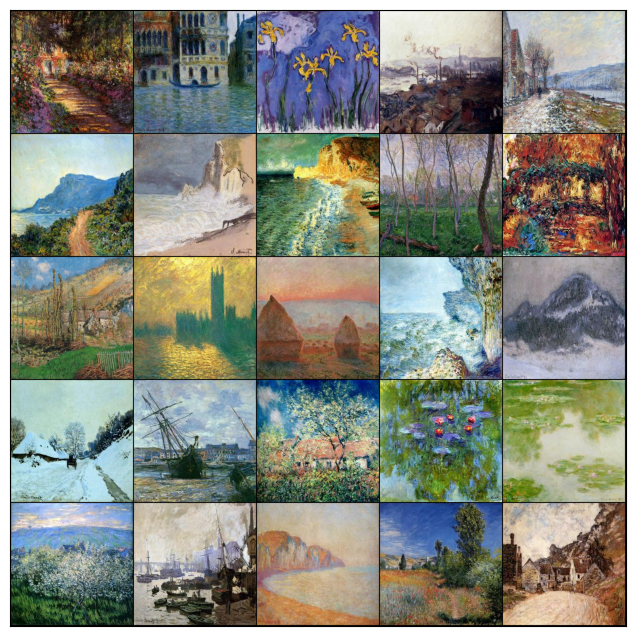

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 100 x 100

    nn.Conv2d(3, 100, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(100),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 100 x 128 x 128

    nn.Conv2d(100, 200, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(200),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 200 x 64 x 64

    nn.Conv2d(200, 300, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(300),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 300 x 32 x 32

    nn.Conv2d(300, 400, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(400),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 400 x 16 x 16

    nn.Conv2d(400, 500, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(500),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 500 x 8 x 8

    nn.Conv2d(500, 600, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(600),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 600 x 4 x 4

    nn.Conv2d(600, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 800

In [20]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 720, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(720),
    nn.ReLU(True),
    # out: 720 x 4 x 4

    nn.ConvTranspose2d(720, 650, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(650),
    nn.ReLU(True),
    # out: 650 x 8 x 8

    nn.ConvTranspose2d(650, 500, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(500),
    nn.ReLU(True),
    # out: 500 x 16 x 16

    nn.ConvTranspose2d(500, 380, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(380),
    nn.ReLU(True),
    # out: 380 x 32 x 32

    nn.ConvTranspose2d(380, 190, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(190),
    nn.ReLU(True),
    # out: 190 x 64 x 64

    nn.ConvTranspose2d(190, 100, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(100),
    nn.ReLU(True),
    # out: 100 x 128 x 128

    nn.ConvTranspose2d(100, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256
)

torch.Size([30, 3, 256, 256])


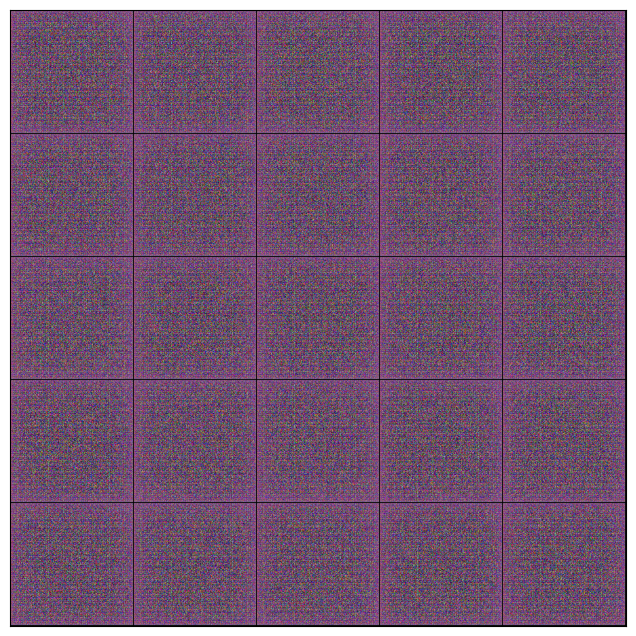

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [32]:
generator = to_device(generator, device)

In [33]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [34]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [35]:
from torchvision.utils import save_image

In [36]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [37]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=5)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=5).permute(1, 2, 0))

In [47]:
fixed_latent = torch.randn(30, latent_size, 1, 1, device=device)

In [39]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [40]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [56]:
lr = 0.001
epochs = 100

In [57]:
history = fit(epochs, lr)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 2.5898, loss_d: 0.0479, real_score: 0.9683, fake_score: 0.0143
Saving generated-images-0001.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 4.7119, loss_d: 0.0614, real_score: 0.9854, fake_score: 0.0411
Saving generated-images-0002.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 7.0085, loss_d: 0.0462, real_score: 0.9867, fake_score: 0.0319
Saving generated-images-0003.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 5.0652, loss_d: 0.4746, real_score: 0.6685, fake_score: 0.0003
Saving generated-images-0004.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 4.2399, loss_d: 0.3553, real_score: 0.7957, fake_score: 0.0655
Saving generated-images-0005.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.6685, loss_d: 0.1432, real_score: 0.9032, fake_score: 0.0341
Saving generated-images-0006.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 3.4940, loss_d: 1.0365, real_score: 0.4259, fake_score: 0.0361
Saving generated-images-0007.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 4.9469, loss_d: 0.1364, real_score: 0.9250, fake_score: 0.0459
Saving generated-images-0008.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 6.9292, loss_d: 0.4372, real_score: 0.9856, fake_score: 0.3227
Saving generated-images-0009.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 4.8099, loss_d: 0.3238, real_score: 0.9810, fake_score: 0.2325
Saving generated-images-0010.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 5.0698, loss_d: 0.3509, real_score: 0.7615, fake_score: 0.0389
Saving generated-images-0011.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 4.5684, loss_d: 0.0822, real_score: 0.9870, fake_score: 0.0656
Saving generated-images-0012.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 6.1777, loss_d: 0.1163, real_score: 0.8966, fake_score: 0.0019
Saving generated-images-0013.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.1592, loss_d: 1.4303, real_score: 0.8617, fake_score: 0.6123
Saving generated-images-0014.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 6.8970, loss_d: 0.3732, real_score: 0.7478, fake_score: 0.0032
Saving generated-images-0015.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.1121, loss_d: 0.3655, real_score: 0.9958, fake_score: 0.2416
Saving generated-images-0016.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 6.0893, loss_d: 0.0289, real_score: 0.9801, fake_score: 0.0085
Saving generated-images-0017.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 6.4707, loss_d: 0.0064, real_score: 0.9944, fake_score: 0.0006
Saving generated-images-0018.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.8094, loss_d: 0.3757, real_score: 0.9974, fake_score: 0.2967
Saving generated-images-0019.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 5.3932, loss_d: 1.8788, real_score: 0.2376, fake_score: 0.0003
Saving generated-images-0020.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 5.7103, loss_d: 0.1763, real_score: 0.8608, fake_score: 0.0088
Saving generated-images-0021.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 2.2047, loss_d: 0.1936, real_score: 0.8489, fake_score: 0.0186
Saving generated-images-0022.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.8208, loss_d: 0.2238, real_score: 0.8483, fake_score: 0.0458
Saving generated-images-0023.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 5.3703, loss_d: 0.0373, real_score: 0.9758, fake_score: 0.0120
Saving generated-images-0024.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 8.3973, loss_d: 1.3974, real_score: 0.9489, fake_score: 0.6654
Saving generated-images-0025.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 5.1823, loss_d: 2.1236, real_score: 0.1656, fake_score: 0.0044
Saving generated-images-0026.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 5.6023, loss_d: 0.9713, real_score: 0.9147, fake_score: 0.5186
Saving generated-images-0027.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.3135, loss_d: 2.1072, real_score: 0.1661, fake_score: 0.0110
Saving generated-images-0028.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.1925, loss_d: 0.4207, real_score: 0.8637, fake_score: 0.2220
Saving generated-images-0029.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.6771, loss_d: 0.5331, real_score: 0.9023, fake_score: 0.3287
Saving generated-images-0030.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 7.4880, loss_d: 2.0516, real_score: 0.2303, fake_score: 0.0005
Saving generated-images-0031.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.4356, loss_d: 0.0279, real_score: 0.9844, fake_score: 0.0119
Saving generated-images-0032.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 8.8319, loss_d: 0.2207, real_score: 0.9337, fake_score: 0.1334
Saving generated-images-0033.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 7.6967, loss_d: 1.0063, real_score: 0.8925, fake_score: 0.5616
Saving generated-images-0034.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.8932, loss_d: 0.1119, real_score: 0.9114, fake_score: 0.0047
Saving generated-images-0035.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 7.5975, loss_d: 0.3803, real_score: 0.9776, fake_score: 0.2659
Saving generated-images-0036.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 5.7139, loss_d: 2.5991, real_score: 0.9905, fake_score: 0.8157
Saving generated-images-0037.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.0721, loss_d: 0.0900, real_score: 0.9919, fake_score: 0.0772
Saving generated-images-0038.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 9.2234, loss_d: 0.3220, real_score: 0.9883, fake_score: 0.2513
Saving generated-images-0039.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 2.1385, loss_d: 0.6522, real_score: 0.9725, fake_score: 0.4318
Saving generated-images-0040.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 5.5649, loss_d: 0.8444, real_score: 0.7876, fake_score: 0.3968
Saving generated-images-0041.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 1.1016, loss_d: 2.3157, real_score: 0.1642, fake_score: 0.0170
Saving generated-images-0042.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.1004, loss_d: 0.9652, real_score: 0.4562, fake_score: 0.0025
Saving generated-images-0043.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.9590, loss_d: 1.6135, real_score: 0.9940, fake_score: 0.7670
Saving generated-images-0044.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 6.6585, loss_d: 0.4402, real_score: 0.9682, fake_score: 0.3054
Saving generated-images-0045.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 4.2238, loss_d: 0.0544, real_score: 0.9673, fake_score: 0.0201
Saving generated-images-0046.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 8.6450, loss_d: 0.5788, real_score: 0.9932, fake_score: 0.4092
Saving generated-images-0047.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 8.6970, loss_d: 1.4066, real_score: 0.9853, fake_score: 0.7007
Saving generated-images-0048.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 5.2675, loss_d: 0.0498, real_score: 0.9805, fake_score: 0.0290
Saving generated-images-0049.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 6.3080, loss_d: 0.3093, real_score: 0.8727, fake_score: 0.0105
Saving generated-images-0050.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.2258, loss_d: 0.4242, real_score: 0.7708, fake_score: 0.1153
Saving generated-images-0051.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.5424, loss_d: 0.3649, real_score: 0.7730, fake_score: 0.0352
Saving generated-images-0052.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.4544, loss_d: 3.9106, real_score: 0.0330, fake_score: 0.0005
Saving generated-images-0053.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 4.7656, loss_d: 0.1099, real_score: 0.9901, fake_score: 0.0862
Saving generated-images-0054.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 6.3496, loss_d: 1.2554, real_score: 0.9864, fake_score: 0.6574
Saving generated-images-0055.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 7.1519, loss_d: 0.6337, real_score: 0.9079, fake_score: 0.3774
Saving generated-images-0056.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 7.4809, loss_d: 0.3647, real_score: 0.9965, fake_score: 0.2823
Saving generated-images-0057.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.5161, loss_d: 0.1058, real_score: 0.9219, fake_score: 0.0196
Saving generated-images-0058.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 8.3328, loss_d: 4.8807, real_score: 0.0126, fake_score: 0.0001
Saving generated-images-0059.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.9922, loss_d: 0.0844, real_score: 0.9683, fake_score: 0.0493
Saving generated-images-0060.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 5.1720, loss_d: 0.2192, real_score: 0.8237, fake_score: 0.0132
Saving generated-images-0061.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 1.2699, loss_d: 2.0878, real_score: 0.1743, fake_score: 0.0239
Saving generated-images-0062.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.8961, loss_d: 0.5556, real_score: 0.5982, fake_score: 0.0029
Saving generated-images-0063.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.4775, loss_d: 1.4461, real_score: 0.3085, fake_score: 0.0026
Saving generated-images-0064.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 7.6968, loss_d: 0.1854, real_score: 0.9818, fake_score: 0.1479
Saving generated-images-0065.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 6.6716, loss_d: 6.9355, real_score: 0.0016, fake_score: 0.0000
Saving generated-images-0066.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.4495, loss_d: 0.1267, real_score: 0.9932, fake_score: 0.1093
Saving generated-images-0067.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 8.0128, loss_d: 0.0157, real_score: 0.9856, fake_score: 0.0010
Saving generated-images-0068.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 5.8005, loss_d: 7.6494, real_score: 0.0011, fake_score: 0.0000
Saving generated-images-0069.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.6843, loss_d: 0.1089, real_score: 0.9089, fake_score: 0.0095
Saving generated-images-0070.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 6.7445, loss_d: 4.1819, real_score: 0.9957, fake_score: 0.9746
Saving generated-images-0071.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 2.1532, loss_d: 1.3521, real_score: 0.4636, fake_score: 0.2769
Saving generated-images-0072.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.6468, loss_d: 0.1614, real_score: 0.9259, fake_score: 0.0775
Saving generated-images-0073.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.7523, loss_d: 0.2077, real_score: 0.9806, fake_score: 0.1639
Saving generated-images-0074.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 2.2452, loss_d: 0.4918, real_score: 0.6881, fake_score: 0.0605
Saving generated-images-0075.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.6287, loss_d: 0.1536, real_score: 0.9427, fake_score: 0.0773
Saving generated-images-0076.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 5.0551, loss_d: 0.1188, real_score: 0.9118, fake_score: 0.0203
Saving generated-images-0077.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 3.0346, loss_d: 0.5183, real_score: 0.6904, fake_score: 0.0326
Saving generated-images-0078.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 5.4638, loss_d: 0.4808, real_score: 0.6749, fake_score: 0.0064
Saving generated-images-0079.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 5.8467, loss_d: 0.3759, real_score: 0.9964, fake_score: 0.2678
Saving generated-images-0080.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.3350, loss_d: 0.1212, real_score: 0.9270, fake_score: 0.0385
Saving generated-images-0081.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.2272, loss_d: 1.2613, real_score: 0.9814, fake_score: 0.6087
Saving generated-images-0082.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 4.5036, loss_d: 0.1950, real_score: 0.8956, fake_score: 0.0665
Saving generated-images-0083.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 5.3108, loss_d: 0.3297, real_score: 0.9744, fake_score: 0.2411
Saving generated-images-0084.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.7290, loss_d: 0.1449, real_score: 0.9900, fake_score: 0.1124
Saving generated-images-0085.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.4252, loss_d: 0.1337, real_score: 0.8845, fake_score: 0.0048
Saving generated-images-0086.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 8.8030, loss_d: 1.3775, real_score: 0.9925, fake_score: 0.6017
Saving generated-images-0087.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.8424, loss_d: 0.1880, real_score: 0.9934, fake_score: 0.1505
Saving generated-images-0088.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 7.6774, loss_d: 0.0627, real_score: 0.9430, fake_score: 0.0013
Saving generated-images-0089.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 7.4101, loss_d: 0.0046, real_score: 0.9970, fake_score: 0.0015
Saving generated-images-0090.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 6.6887, loss_d: 0.1025, real_score: 0.9171, fake_score: 0.0104
Saving generated-images-0091.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.8684, loss_d: 0.3794, real_score: 0.9572, fake_score: 0.2427
Saving generated-images-0092.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 3.2972, loss_d: 0.8979, real_score: 0.4741, fake_score: 0.0470
Saving generated-images-0093.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 5.3212, loss_d: 0.2144, real_score: 0.8518, fake_score: 0.0309
Saving generated-images-0094.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 5.3180, loss_d: 0.2166, real_score: 0.8217, fake_score: 0.0057
Saving generated-images-0095.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 5.0864, loss_d: 0.7096, real_score: 0.9701, fake_score: 0.3887
Saving generated-images-0096.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 8.2450, loss_d: 0.0141, real_score: 0.9872, fake_score: 0.0011
Saving generated-images-0097.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 2.2203, loss_d: 0.1418, real_score: 0.9581, fake_score: 0.0863
Saving generated-images-0098.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 2.6805, loss_d: 0.1195, real_score: 0.9156, fake_score: 0.0263
Saving generated-images-0099.png


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 7.5281, loss_d: 0.8374, real_score: 0.9717, fake_score: 0.4888
Saving generated-images-0100.png


In [43]:
losses_g, losses_d, real_scores, fake_scores = history

In [58]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [45]:
from IPython.display import Image

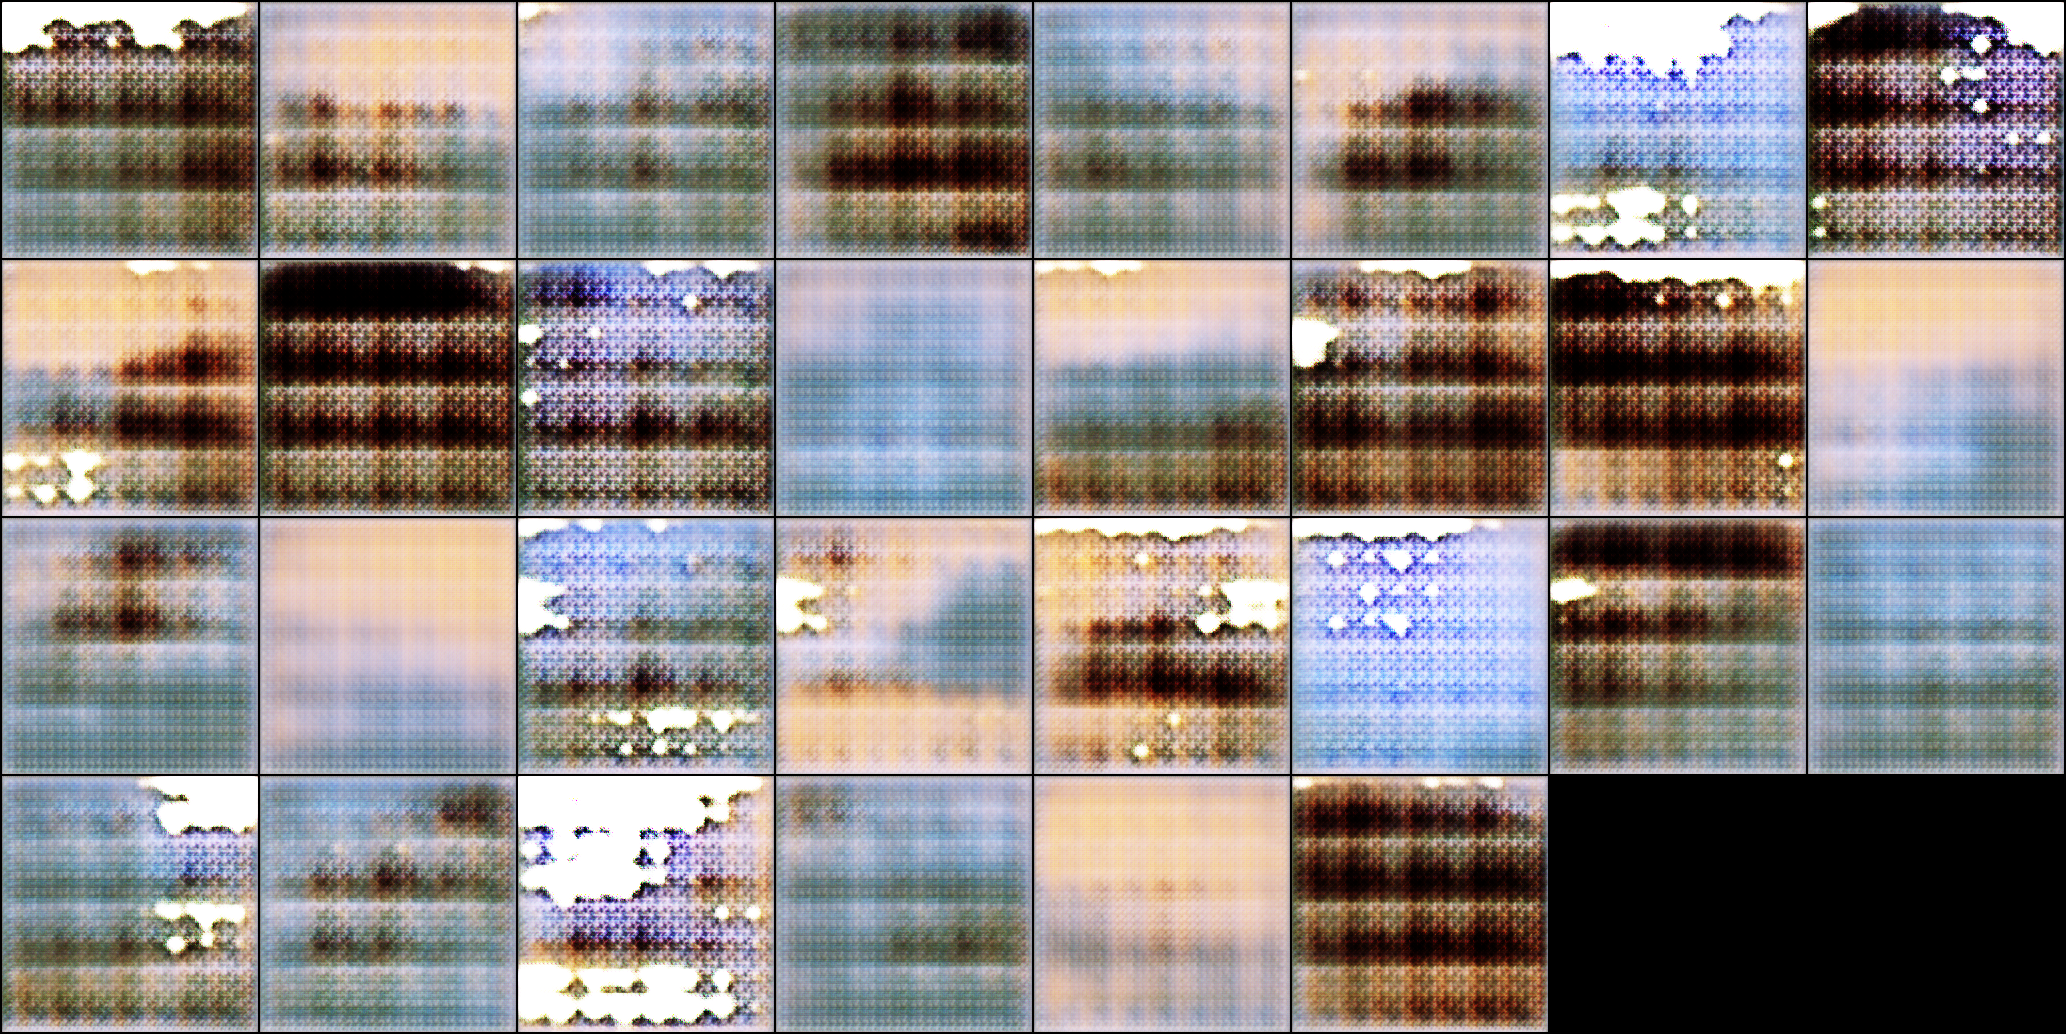

In [59]:
Image('./generated/generated-images-0100.png')